In [2]:
from typing import re

import pandas as pd

# Read the CSV file
filename = 'tts_1_asis.csv'
df = pd.read_csv(filename)
df = df.drop(columns=['Time'])
# Calculate the average over each column
averages = df.mean()

# Print the averages
print(averages)

Power Plug Energy Report         41.515065
Scaphandre Host Usage             8.726509
Average over 30m (Power Plug)    42.235247
Average Over 30m (Scaphandre)     9.240455
dtype: float64


In [4]:
df = pd.read_csv('tts_1_asis.csv')

# Calculate variance for the relevant columns
variance_power_plug = df['Power Plug Energy Report'].var()
variance_scaphandre = df['Scaphandre Host Usage'].var()
variance_avg_power_plug = df['Average over 30m (Power Plug)'].var()
variance_avg_scaphandre = df['Average Over 30m (Scaphandre)'].var()

# Print the results
print(f"Variance of Power Plug Energy Report: {variance_power_plug}")
print(f"Variance of Scaphandre Host Usage: {variance_scaphandre}")
print(f"Variance of Average over 30m (Power Plug): {variance_avg_power_plug}")
print(f"Variance of Average Over 30m (Scaphandre): {variance_avg_scaphandre}")

Variance of Power Plug Energy Report: 2.877014088442277
Variance of Scaphandre Host Usage: 1.411303849599104
Variance of Average over 30m (Power Plug): 3.7798149416522606
Variance of Average Over 30m (Scaphandre): 2.0061024096455675


2.6666666666666665


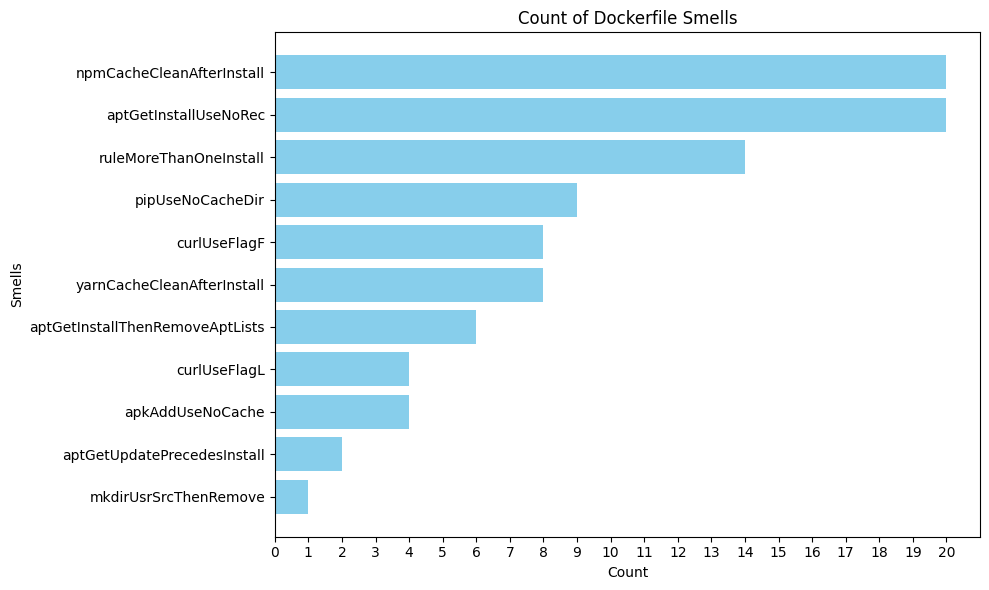

In [18]:
import json
import matplotlib.pyplot as plt

with open("./scraper/dockerfiles_with_smells.json", 'r') as file:
    excluded_smells = {"DL3027", "DL3020", "DL3002", "DL3046", "DL3004"}
    data = json.load(file)
    smells_count = {}

    for key in data.keys():
        for item in data[key]:
            for smell in item['smells']:
                if smell not in excluded_smells:
                    if smell in smells_count:
                        smells_count[smell] += 1
                    else:
                        smells_count[smell] = 1

    sorted_smells_count = dict(sorted(smells_count.items(), key=lambda item: item[1], reverse=False))

    total_smells = 0
    dockerfile_count = 0

    for key in data.keys():
        for item in data[key]:
            filtered_smells = [smell for smell in item['smells'] if smell not in excluded_smells]
            total_smells += len(filtered_smells)
            dockerfile_count += 1

    average_smells = total_smells / dockerfile_count
    print(average_smells)

    # Plotting the horizontal bar chart
    smells = list(sorted_smells_count.keys())
    counts = list(sorted_smells_count.values())

    plt.figure(figsize=(10, 6))
    plt.barh(smells, counts, color='skyblue')
    plt.xlabel('Count')
    plt.ylabel('Smells')
    plt.title('Count of Dockerfile Smells')
    plt.tight_layout()

    # Ensuring x-axis ticks are whole numbers
    plt.xticks(range(0, max(counts) + 1, 1))

    # Saving the plot to a file
    plt.savefig("count.png")
    plt.show()

In [38]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import re

report_directory = "./scraper/data"
available_reports = []
for filename in os.listdir(report_directory):
    if filename.endswith('.json'):
        available_reports.append(os.path.join(report_directory, filename))


In [60]:
rtype = "scaph"
repetition = "1"
name = ".*chat.*"
smell = ".*"
githash = ".*"
selected_reports = list(
    filter(lambda s: re.compile(rf'.*{rtype}_{repetition}_{name}_{smell}_{githash}.*').match(s), available_reports))

selected_reports

['./scraper/data/scaph_1_chatgpt-next-web_1_c359b30763224d4e5cb264adc02b5436982e3493.json',
 './scraper/data/scaph_1_chatgpt-next-web_2_c359b30763224d4e5cb264adc02b5436982e3493.json',
 './scraper/data/scaph_1_chatgpt-next-web_4_c359b30763224d4e5cb264adc02b5436982e3493.json',
 './scraper/data/scaph_1_chatgpt-next-web_3_c359b30763224d4e5cb264adc02b5436982e3493.json']

In [91]:
import pandas as pd

def read_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        values = data['result'][0]['values']
        readings = [float(v[1]) for v in values]
        return readings


data = [read_file(report) for report in selected_reports]
df = pd.DataFrame(data)
column_averages = df.mean()
column_averages_df = pd.DataFrame([column_averages],index=['Average'])
df = column_averages_df

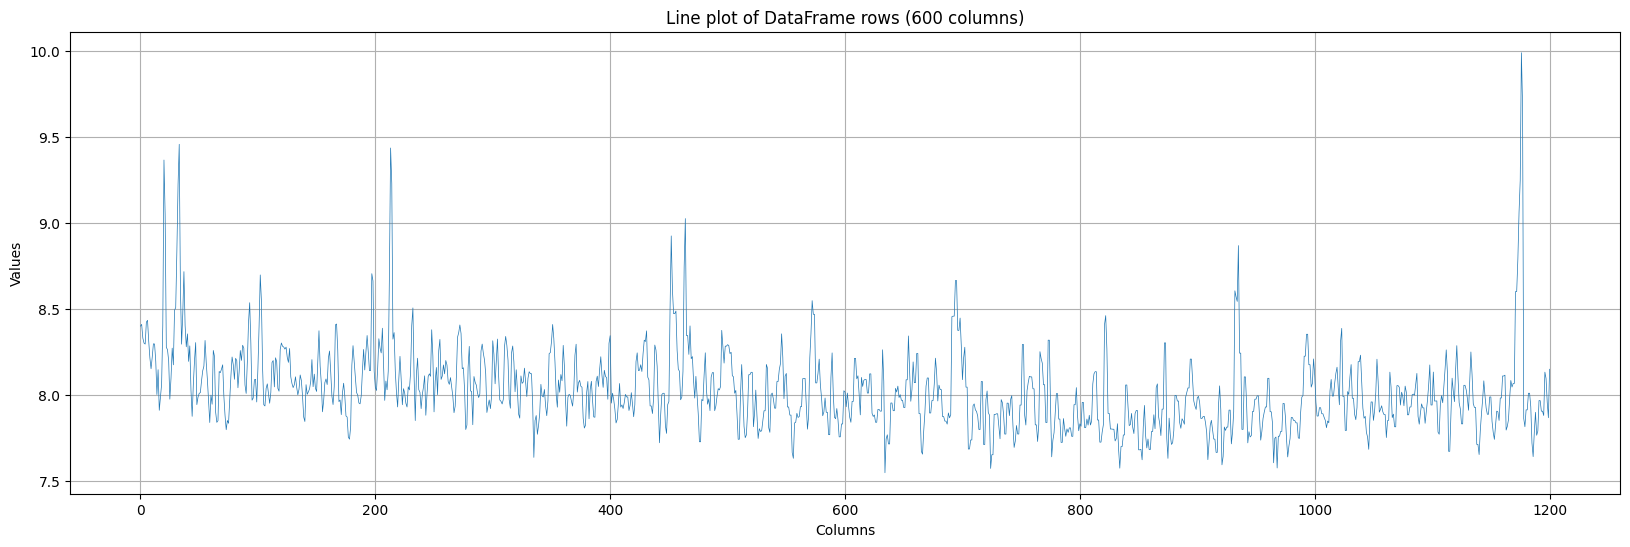

In [92]:
plt.figure(figsize=(20, 6))

for index, row in df.iterrows():
    plt.plot(df.columns, row, linewidth=0.5)

plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Line plot of DataFrame rows (600 columns)')
plt.grid(True)
plt.show()


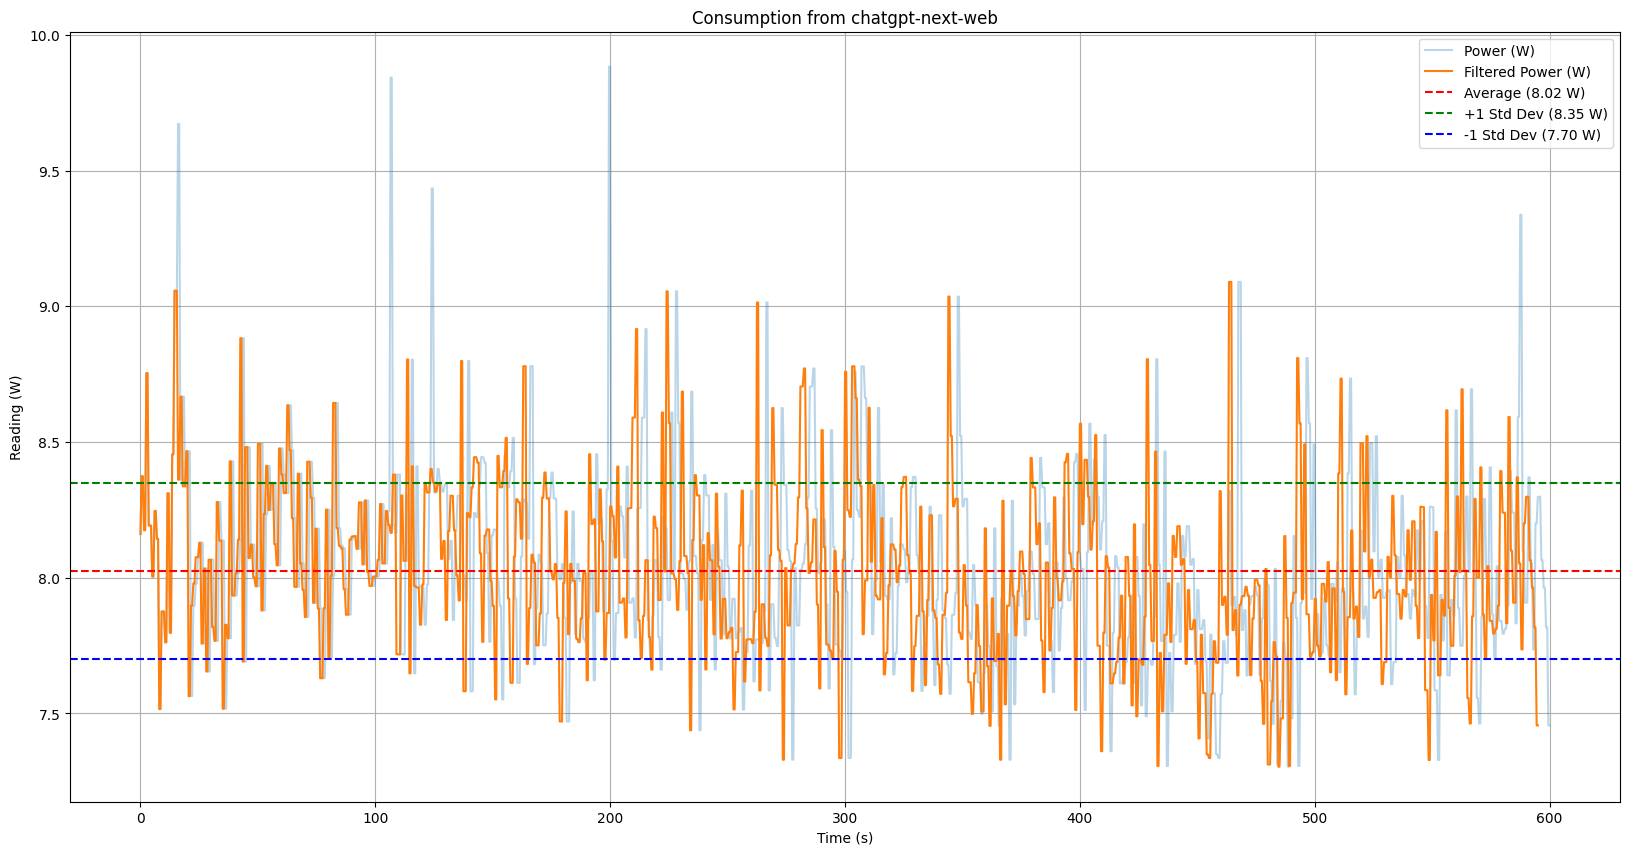

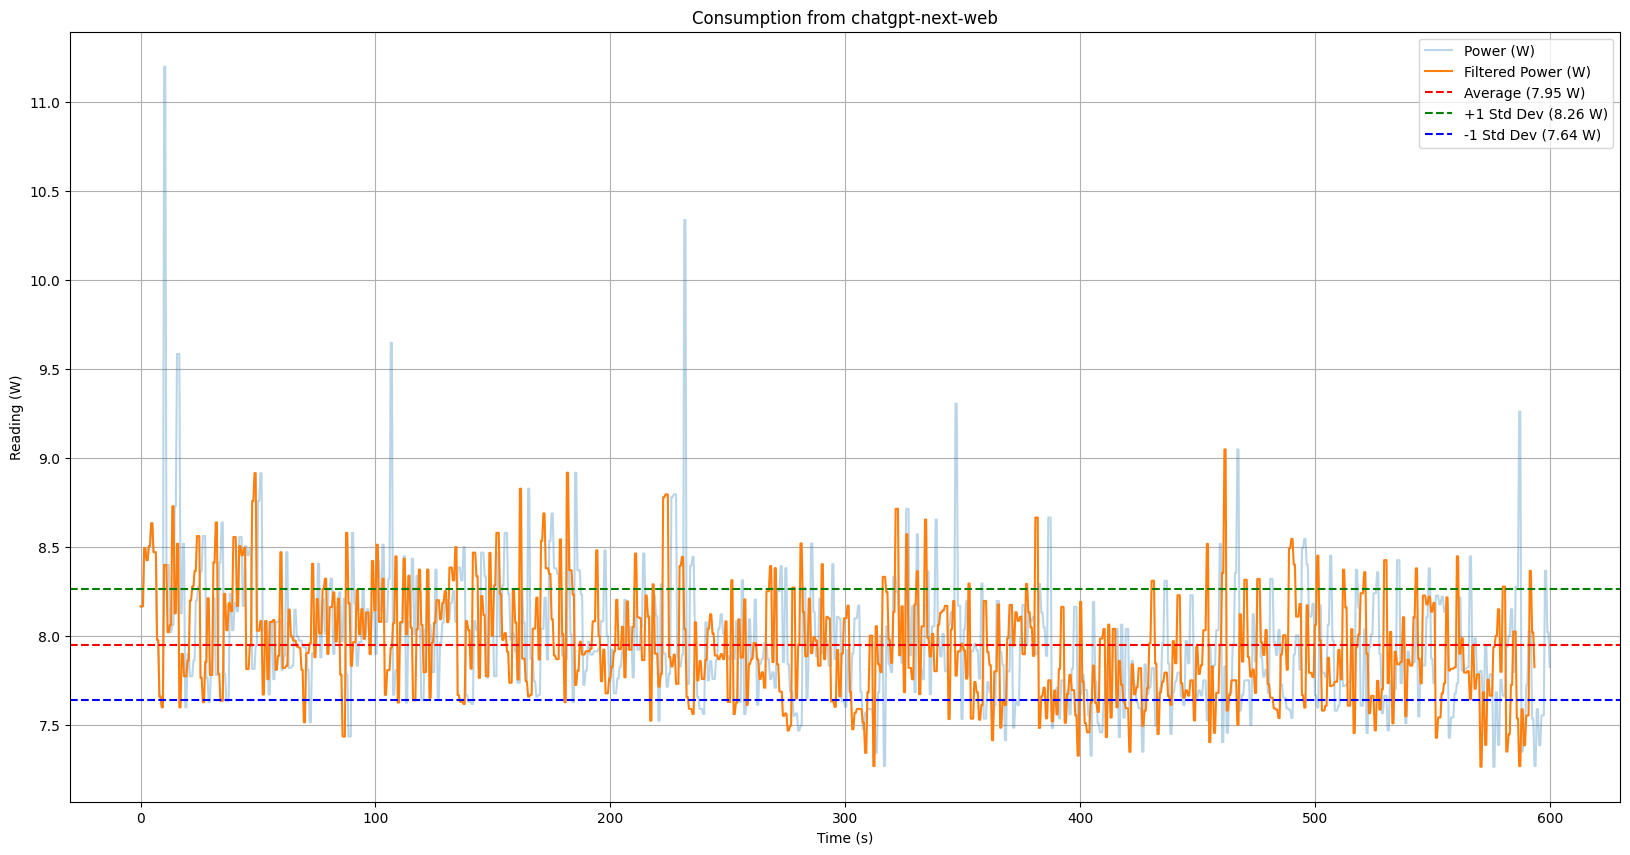

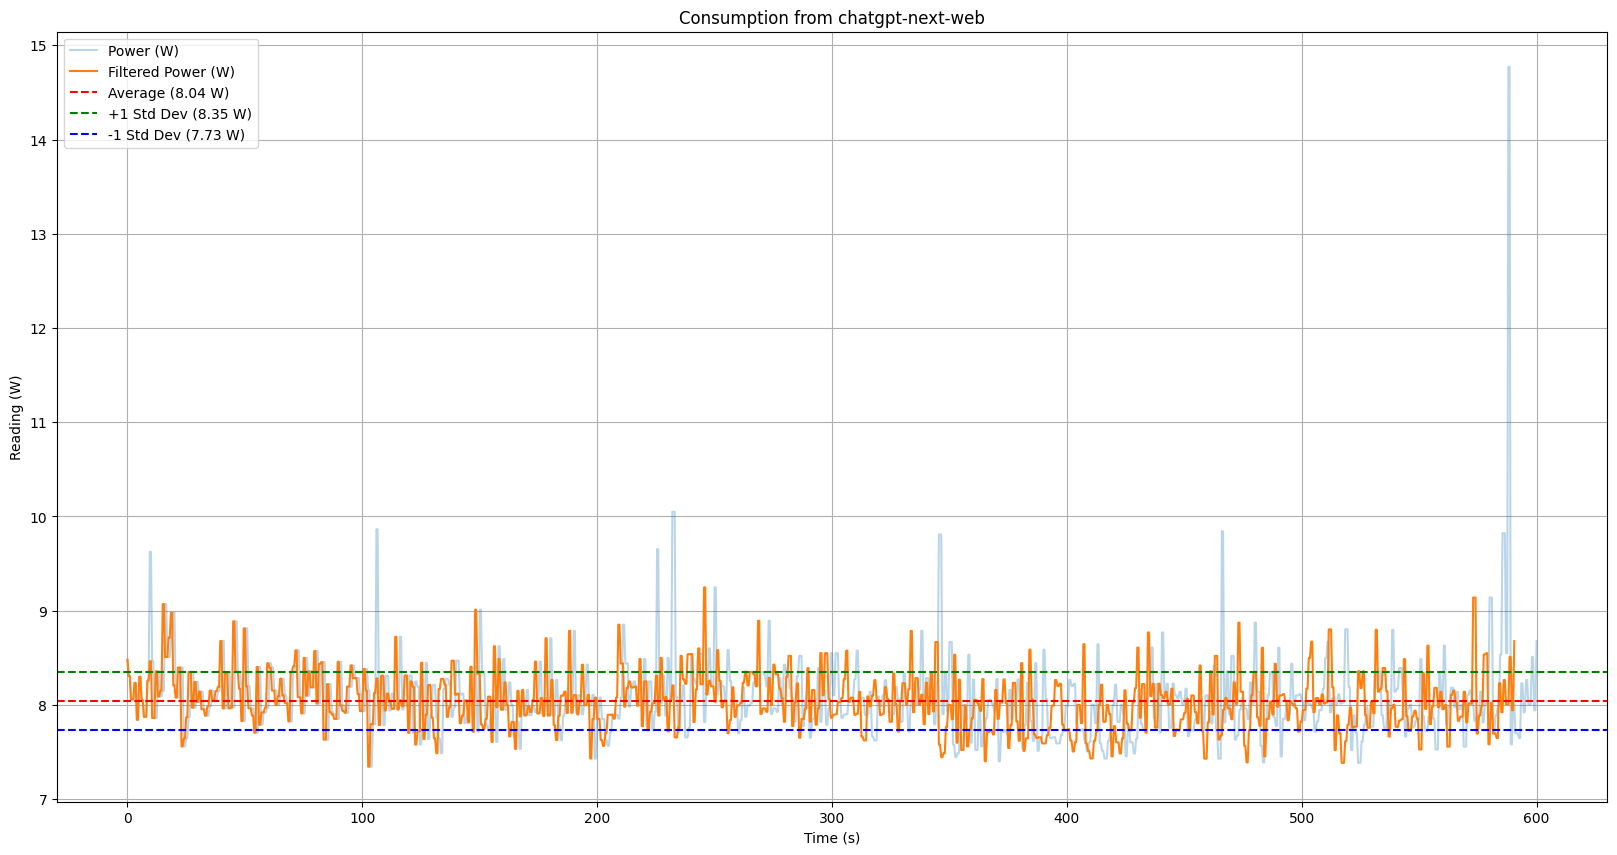

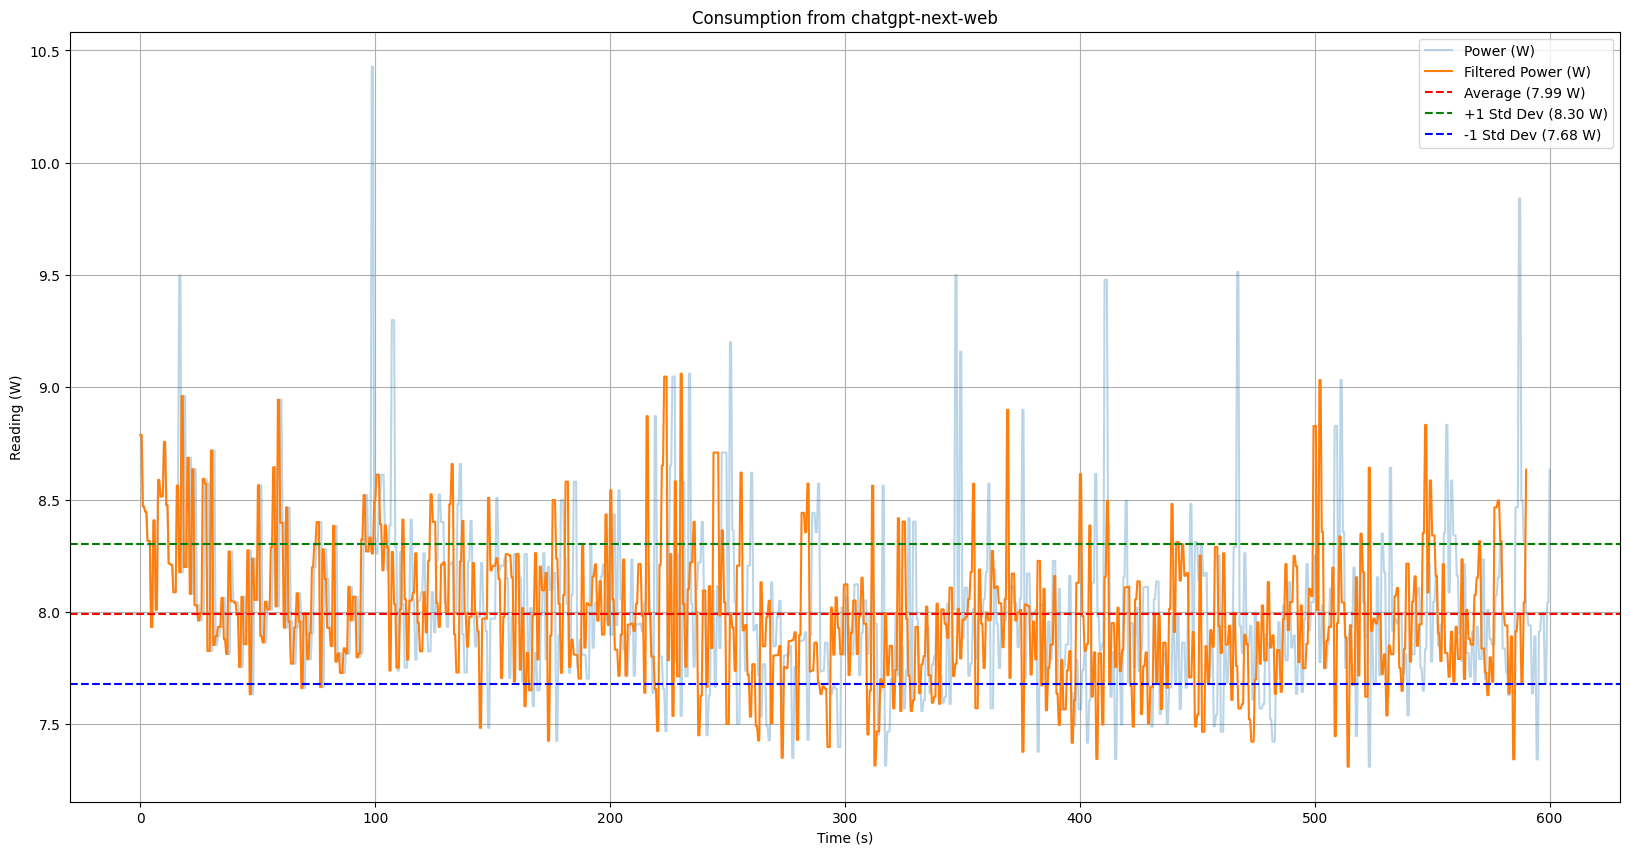

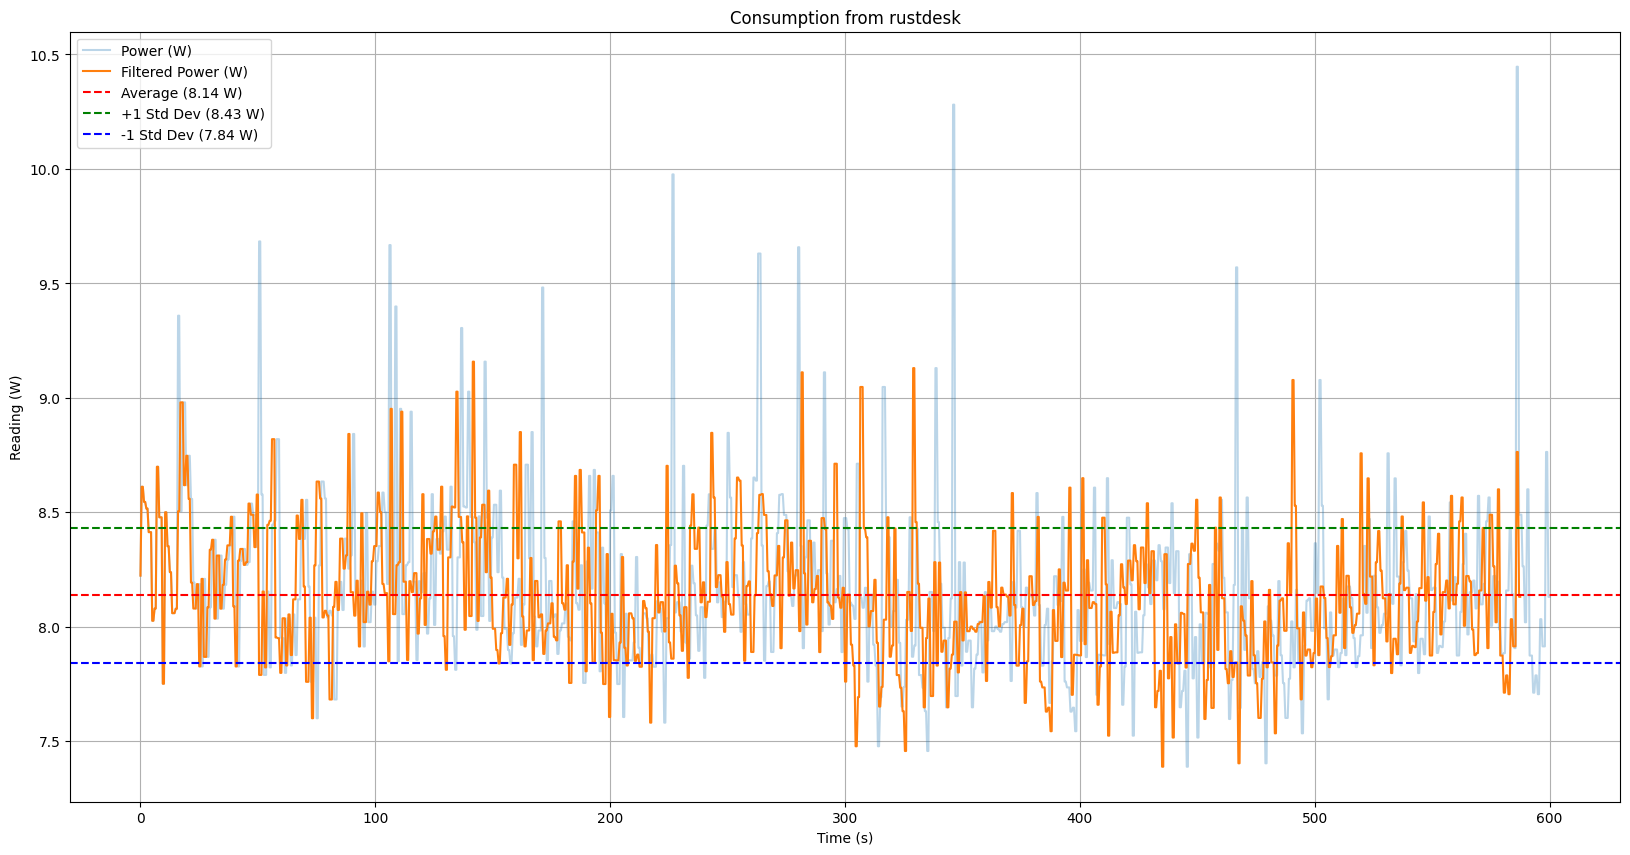

In [27]:


def remove_outliers_edge(readings, timestamps, edge_fraction=0.1, threshold=2):
    edge_count = int(len(readings) * edge_fraction)

    # More aggressive outlier removal at the edges
    readings_start = readings[:edge_count]
    readings_end = readings[-edge_count:]

    mean_start = np.mean(readings_start)
    std_dev_start = np.std(readings_start)
    lower_bound_start = mean_start - threshold * std_dev_start
    upper_bound_start = mean_start + threshold * std_dev_start

    mean_end = np.mean(readings_end)
    std_dev_end = np.std(readings_end)
    lower_bound_end = mean_end - threshold * std_dev_end
    upper_bound_end = mean_end + threshold * std_dev_end

    filtered_readings = []
    filtered_timestamps = []

    for i, reading in enumerate(readings):
        if i < edge_count:
            if lower_bound_start < reading < upper_bound_start:
                filtered_readings.append(reading)
                filtered_timestamps.append(timestamps[i])
        elif i >= len(readings) - edge_count:
            if lower_bound_end < reading < upper_bound_end:
                filtered_readings.append(reading)
                filtered_timestamps.append(timestamps[i])
        else:
            filtered_readings.append(reading)
            filtered_timestamps.append(timestamps[i])

    return filtered_timestamps, filtered_readings


def plot_values(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        values = data['result'][0]['values']
        timestamps = [v[0] for v in values]
        readings = [float(v[1]) for v in values]

        # Convert timestamps to start from 0
        base_timestamp = timestamps[0]
        adjusted_timestamps = [t - base_timestamp for t in timestamps]

        # Remove outliers with a less aggressive threshold
        filtered_readings = remove_outliers(readings)



def search(str, type, repetition, smell, githash):
    regex_str = rf'^{type}_{repetition}_.*_{smell}_{githash}.*'
    regex = re.compile(regex_str)
    return bool(regex.match(str))


# Function to process all JSON files in a directory
def process_directory(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.json') and search(filename, "scaph", "1", ".*", ".*"):
            plot_values(os.path.join(directory, filename))


# Directory containing the JSON files
directory = './scraper/data'  # Replace with your directory path

# Process the directory
process_directory(directory)
